In [35]:
import os
from dotenv import load_dotenv
import json
import pandas as pd
import ast
from openai import OpenAI
# from serpapi import Client as SerpApiClient
import requests
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

load_dotenv()

# 定义所需的环境变量
REQUIRED_VARS = [
    "OPENROUTER_API_KEY",
    "OPENROUTER_BASE_URL",
    "SERPER_API_KEY"
]

# 使用字典推导式加载配置，同时检查缺失项
config = {var: os.environ.get(var) for var in REQUIRED_VARS}
missing_vars = [var for var, value in config.items() if not value]

if missing_vars:
    raise ValueError(f"错误: 缺少必要的环境变量: {', '.join(missing_vars)}")

In [36]:
# --- Model Selection ---
# We use a powerful model to create the "ground truth" labels.
GOLD_STANDARD_MODEL = "google/gemini-2.5-flash"
# This is the smaller, cheaper model we are testing.
VERIFIER_MODEL = "google/gemini-2.5-flash-lite" 

# --- Files and Samples ---
INPUT_FILE = "experiment_2_detailed_results.csv" # Using results from the previous step
OUTPUT_DATASET_FILE = "experiment_3_test_dataset.csv"
OUTPUT_CHART_ACCURACY = "figure_5_verifier_accuracy.png"
OUTPUT_CHART_CONFUSION_MATRIX = "figure_6_verifier_confusion_matrix.png"
NUM_SAMPLES_PER_CLASS = 30 # Aim for this many samples for Supports, Refutes, and Neutral classes

In [37]:
# --- Prompt Templates ---
GOLD_STANDARD_PROMPT = """
You are a highly precise linguistic annotator. Your task is to provide a ground truth label for the relationship between a "Knowledge Triple" and "Evidence Snippets".
You must base your decision *only* on the provided snippets. Your response must be a single word: Supports, Refutes, or Neutral.

- Supports: The snippets directly state or strongly imply the triple is true.
- Refutes: The snippets directly state or strongly imply the triple is false.
- Neutral: The snippets are irrelevant, ambiguous, or do not contain enough information.

Knowledge Triple: {triple}
Evidence Snippets:
---
{snippets}
---

Your single-word response:
"""

VERIFIER_PROMPT = """
你是一个事实核查员。请判断以下“证据文本”是否支持、反驳或与给出的“知识断言”无关。
你的回答只能是 "Supports", "Refutes", 或 "Neutral" 中的一个。

知识断言: {triple}
证据文本:
---
{snippets}
---

判断:
"""

In [38]:
client = OpenAI(
    api_key=config["OPENROUTER_API_KEY"], 
    base_url=config["OPENROUTER_BASE_URL"]
    )

In [39]:
# from 02.ipynb
import requests

SERPER_API_KEY = config["SERPER_API_KEY"]
QUERY_GENERATOR_MODEL = "google/gemini-2.5-flash-lite"
REVISED_QUERY_GENERATION_PROMPT = """
You are an expert search engine user. Your primary task is to generate effective Google search queries to verify a given knowledge triple.

First, think step-by-step about what information is needed to verify the triple.
Then, generate up to 3 diverse and concise queries based on your thinking.

Knowledge Triple: {triple}

Your final output MUST be a JSON object with a single key "queries" containing a list of strings.
Example: {{"queries": ["when did Queen Victoria marry Prince Albert", "Queen Victoria Prince Albert wedding date"]}}
"""

def generate_queries_from_triple(triple: tuple) -> list:
    """
    Generates search queries from a triple with enhanced, robust parsing and debugging.
    """
    try:
        prompt = REVISED_QUERY_GENERATION_PROMPT.format(triple=str(triple))
        response = client.chat.completions.create(
            model=QUERY_GENERATOR_MODEL,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2,
            response_format={"type": "json_object"}
        )
        content = response.choices[0].message.content

        # --- 关键修改 1: 打印原始输出 (让我们看看模型到底返回了什么) ---
        print(f"\n[DEBUG] Raw output for triple {triple}: {content}")

        # --- 关键修改 2: 更稳健的解析逻辑 ---
        if not content:
            print("[WARN] LLM returned empty content.")
            return []

        data = json.loads(content)
        
        # 检查解析后的数据是不是一个字典
        if not isinstance(data, dict):
            print(f"[WARN] LLM output was valid JSON, but not a dictionary (dict). Got type: {type(data)}")
            return []
            
        # 使用 .get() 方法安全地获取键值，如果键不存在，则返回默认值(空列表)
        queries = data.get("queries", [])
        
        if not queries:
             print(f"[WARN] Parsed JSON, but the 'queries' key was missing or its value was empty. Keys found: {list(data.keys())}")

        return queries

    except json.JSONDecodeError:
        # 这个错误会在模型返回了非JSON字符串时触发
        print(f"\n[ERROR] JSONDecodeError: The model did not return a valid JSON string for triple: {triple}.")
        return []
    except Exception as e:
        # 捕获其他所有可能的错误
        print(f"\n[ERROR] An unexpected error occurred in generate_queries_from_triple for {triple}. Error: {e}")
        return []

def execute_search(query: str) -> str:
    """
    Executes a search query using the Serper.dev API.
    """
    url = "https://google.serper.dev/search"
    payload = json.dumps({
        "q": query,
        "num": 3  # Get top 3 results
    })
    headers = {
        'X-API-KEY': SERPER_API_KEY,
        'Content-Type': 'application/json'
    }
    
    try:
        response = requests.request("POST", url, headers=headers, data=payload)
        response.raise_for_status()  # Will raise an exception for HTTP error codes
        
        results = response.json()
        snippets = [res.get("snippet", "") for res in results.get("organic", [])]
        return "\n".join(filter(None, snippets))
        
    except requests.exceptions.RequestException as e:
        print(f"\n[Error] Serper API call failed: {e}")
        return "SEARCH_API_ERROR"
    except json.JSONDecodeError:
        print(f"\n[Error] Failed to decode JSON response from Serper.")
        return "SEARCH_API_ERROR"

In [40]:
def call_llm(prompt, model, is_json=False):
    """A generic wrapper for LLM calls."""
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
            response_format={"type": "json_object"} if is_json else None
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"LLM call failed for model {model}. Error: {e}")
        return None

def prepare_dataset():
    """
    Prepares a balanced dataset for the verifier test, NOW INCLUDING 'REFUTES' SAMPLES.
    This version has the corrected prompt for generating refutes.
    """
    print("--- Step 1: Preparing Test Dataset (Corrected Logic) ---")
    
    # Define the output file and delete it if it exists to ensure regeneration
    dataset_file = OUTPUT_DATASET_FILE
    if os.path.exists(dataset_file):
        os.remove(dataset_file)
        print(f"Deleted old dataset '{dataset_file}' to regenerate with new logic.")

    df_exp1 = pd.read_csv(INPUT_FILE.replace("experiment_2_detailed_results", "experiment_1_auto_evaluated"))
    
    test_data = []
    supports_samples = []

    # 1. Gather "Supports" samples first
    print("Gathering 'Supports' samples...")
    source_rows = df_exp1.head(NUM_SAMPLES_PER_CLASS * 3)
    with tqdm(total=NUM_SAMPLES_PER_CLASS, desc="Supports") as pbar:
        for _, row in source_rows.iterrows():
            if len(supports_samples) >= NUM_SAMPLES_PER_CLASS: break
            triples = ast.literal_eval(row['parsed_triples'])
            for triple in triples:
                if len(supports_samples) >= NUM_SAMPLES_PER_CLASS: break
                queries = generate_queries_from_triple(tuple(triple))
                time.sleep(0.5)
                if queries:
                    snippets = execute_search(queries[0])
                    time.sleep(0.5)
                    label = call_llm(GOLD_STANDARD_PROMPT.format(triple=str(triple), snippets=snippets), GOLD_STANDARD_MODEL)
                    if label == "Supports":
                        sample = {"triple": str(triple), "snippets": snippets, "golden_label": "Supports"}
                        supports_samples.append(sample)
                        test_data.append(sample)
                        pbar.update(1)
    
    # --- THIS IS THE CORRECTED PROMPT ---
    refutes_prompt = """
    Given a true knowledge triple, create a plausible but false version of it by changing only the object.
    Original True Triple: {triple}
    Your task is to respond in JSON format with a single key "false_triple".
    Example: {{"false_triple": ["TSMC", "headquartered_in", "Shanghai"]}}
    """
    
    # 2. Generate "Refutes" samples using counterfactuals
    print("Generating 'Refutes' samples...")
    with tqdm(total=NUM_SAMPLES_PER_CLASS, desc="Refutes") as pbar:
        # Shuffle to ensure we don't always use the first N samples
        for sample in random.sample(supports_samples, len(supports_samples)):
            if len([d for d in test_data if d['golden_label'] == 'Refutes']) >= NUM_SAMPLES_PER_CLASS: break
            
            true_triple_str = sample['triple']
            true_snippets = sample['snippets']
            
            res = call_llm(refutes_prompt.format(triple=true_triple_str), GOLD_STANDARD_MODEL, is_json=True)
            time.sleep(0.5)

            if res:
                try:
                    false_triple_list = json.loads(res).get("false_triple")
                    if false_triple_list:
                        false_triple_str = str(false_triple_list)
                        # Verify that this new pairing is indeed a "Refutes" case
                        label = call_llm(GOLD_STANDARD_PROMPT.format(triple=false_triple_str, snippets=true_snippets), GOLD_STANDARD_MODEL)
                        time.sleep(0.5)
                        if label == "Refutes":
                            test_data.append({"triple": false_triple_str, "snippets": true_snippets, "golden_label": "Refutes"})
                            pbar.update(1)
                except (json.JSONDecodeError, AttributeError) as e:
                    print(f"Could not parse 'false_triple' response: {res}, Error: {e}")

    # 3. Generate "Neutral" samples
    print("Generating 'Neutral' samples...")
    # Ensure we have enough source material
    all_snippets = [d['snippets'] for d in supports_samples]
    all_triples = [d['triple'] for d in supports_samples]
    
    if not all_snippets or not all_triples:
        print("Not enough 'Supports' samples to generate 'Neutral' samples. Aborting.")
        return pd.DataFrame() # Return empty dataframe

    with tqdm(total=NUM_SAMPLES_PER_CLASS, desc="Neutral") as pbar:
        attempts = 0
        while len([d for d in test_data if d['golden_label'] == 'Neutral']) < NUM_SAMPLES_PER_CLASS and attempts < NUM_SAMPLES_PER_CLASS * 5:
            triple = random.choice(all_triples)
            snippet = random.choice(all_snippets)
            # Verify that the random pairing is indeed Neutral
            label = call_llm(GOLD_STANDARD_PROMPT.format(triple=triple, snippets=snippet), GOLD_STANDARD_MODEL)
            time.sleep(0.5)
            if label == "Neutral":
                test_data.append({"triple": triple, "snippets": snippet, "golden_label": "Neutral"})
                pbar.update(1)
            attempts += 1


    dataset_df = pd.DataFrame(test_data)
    dataset_df.to_csv(OUTPUT_DATASET_FILE, index=False)
    print(f"Generated and saved new balanced dataset to {OUTPUT_DATASET_FILE}")
    return dataset_df


def run_verifier_test(dataset_df: pd.DataFrame):
    """Runs the Verifier model on the prepared dataset."""
    print(f"\n--- Step 2: Running Verifier Model ({VERIFIER_MODEL}) on {len(dataset_df)} samples ---")
    predictions = []
    for _, row in tqdm(dataset_df.iterrows(), total=len(dataset_df)):
        prompt = VERIFIER_PROMPT.format(triple=row['triple'], snippets=row['snippets'])
        prediction = call_llm(prompt, VERIFIER_MODEL)
        time.sleep(0.5) # Rate limiting
        predictions.append(prediction)
    
    dataset_df['predicted_label'] = predictions
    return dataset_df


def analyze_and_visualize(final_df: pd.DataFrame):
    """Calculates metrics and creates visualizations."""
    print("\n--- Step 3: Analyzing Results ---")
    
    # Filter out failed predictions
    final_df.dropna(subset=['golden_label', 'predicted_label'], inplace=True)
    labels = ["Supports", "Refutes", "Neutral"]
    
    # 1. Classification Report
    print("Classification Report:")
    report = classification_report(final_df['golden_label'], final_df['predicted_label'], labels=labels, zero_division=0)
    print(report)
    
    # 2. Overall Accuracy
    accuracy = accuracy_score(final_df['golden_label'], final_df['predicted_label'])
    print(f"Overall Accuracy: {accuracy:.2%}")
    
    # 3. Plotting: Overall Accuracy Bar Chart
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="whitegrid")
    acc_bar = sns.barplot(x=["Overall Accuracy"], y=[accuracy], palette=["cornflowerblue"])
    plt.axhline(y=0.90, color='r', linestyle='--', label='Success Threshold (90%)')
    plt.title(f'Verifier Model ({VERIFIER_MODEL}) Accuracy', fontsize=16)
    plt.ylabel('Accuracy Score')
    plt.ylim(0, 1.05)
    plt.text(0, accuracy, f'{accuracy:.2%}', ha='center', va='bottom', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTPUT_CHART_ACCURACY)
    print(f"Accuracy chart saved to {OUTPUT_CHART_ACCURACY}")

    # 4. Plotting: Confusion Matrix
    cm = confusion_matrix(final_df['golden_label'], final_df['predicted_label'], labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {VERIFIER_MODEL}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(OUTPUT_CHART_CONFUSION_MATRIX)
    print(f"Confusion matrix saved to {OUTPUT_CHART_CONFUSION_MATRIX}")

In [41]:
def main():
    """Main function to run the entire experiment."""
    # Step 1: Create the ground truth dataset
    test_dataset = prepare_dataset()
    
    # Step 2: Run the model under test
    results_df = run_verifier_test(test_dataset)
    
    # Step 3: Analyze and visualize the results
    analyze_and_visualize(results_df)

--- Step 1: Preparing Test Dataset (Corrected Logic) ---
Gathering 'Supports' samples...


Supports:   0%|          | 0/30 [00:00<?, ?it/s]


[DEBUG] Raw output for triple ('Scott Derrickson', 'nationality', 'American'): {"queries": ["Scott Derrickson nationality", "Is Scott Derrickson American?", "Scott Derrickson biography"]}


Supports:   3%|▎         | 1/30 [00:05<02:37,  5.43s/it]


[DEBUG] Raw output for triple ('Ed Wood', 'nationality', 'American'): {"queries": ["Ed Wood nationality", "Is Ed Wood American?", "Ed Wood biography nationality"]}


Supports:   7%|▋         | 2/30 [00:09<02:09,  4.63s/it]


[DEBUG] Raw output for triple ('Scott Derrickson', 'is same nationality as', 'Ed Wood'): {"queries": ["Scott Derrickson nationality", "Ed Wood nationality", "Scott Derrickson Ed Wood nationality comparison"]}

[DEBUG] Raw output for triple ('Corliss Archer', 'portrayed by', 'Shirley Temple'): {"queries": ["Corliss Archer Shirley Temple", "who played Corliss Archer", "Shirley Temple filmography Corliss Archer"]}


Supports:  10%|█         | 3/30 [00:18<02:52,  6.40s/it]


[DEBUG] Raw output for triple ('Shirley Temple', 'acted in', 'Kiss and Tell'): {"queries": ["Shirley Temple filmography", "Shirley Temple Kiss and Tell role", "Kiss and Tell cast Shirley Temple"]}

[DEBUG] Raw output for triple ('Shirley Temple', 'held position', 'Ambassador to Ghana'): {"queries": ["Shirley Temple ambassador Ghana", "Shirley Temple diplomatic career", "When was Shirley Temple appointed Ambassador to Ghana?"]}


Supports:  13%|█▎        | 4/30 [00:27<03:23,  7.82s/it]


[DEBUG] Raw output for triple ('Shirley Temple', 'held position', 'Ambassador to Czechoslovakia'): {"queries": ["Shirley Temple ambassador Czechoslovakia", "Shirley Temple diplomatic career", "When was Shirley Temple appointed Ambassador to Czechoslovakia?"]}


Supports:  17%|█▋        | 5/30 [00:31<02:36,  6.25s/it]


[DEBUG] Raw output for triple ('Shirley Temple', 'held position', 'Chief of Protocol of the United States'): {"queries": ["Shirley Temple Chief of Protocol of the United States", "Shirley Temple government positions", "Shirley Temple diplomatic career"]}


Supports:  20%|██        | 6/30 [00:35<02:13,  5.57s/it]


[DEBUG] Raw output for triple ('Shirley Temple', 'held position', 'United States Representative to the United Nations General Assembly'): {"queries": ["Shirley Temple United States Representative to the United Nations General Assembly", "Shirley Temple UN General Assembly position", "Shirley Temple political career UN"]}


Supports:  23%|██▎       | 7/30 [00:39<01:53,  4.93s/it]


[DEBUG] Raw output for triple ('Series', 'hasGenre', 'Science Fantasy'): {"queries": ["list of science fantasy TV series", "what defines science fantasy genre in TV shows", "examples of science fantasy series"]}

[DEBUG] Raw output for triple ('Series', 'hasGenre', 'Young Adult'): {"queries": ["what defines a young adult series", "examples of young adult series", "list of young adult fiction series"]}


Supports:  27%|██▋       | 8/30 [00:48<02:17,  6.24s/it]


[DEBUG] Raw output for triple ('Series', 'hasNarrativePerspective', 'First Person'): {"queries": ["define narrative perspective in literature", "examples of first person narrative in TV series", "what is first person narrative perspective"]}

[DEBUG] Raw output for triple ('Series', 'hasCompanionBooks', 'Companion Books'): {"queries": ["what are companion books for a series", "examples of series with companion books", "define companion books in literature"]}

[DEBUG] Raw output for triple ('Companion Books', 'narratesAbout', 'Enslaved Worlds'): {"queries": ["\"Companion Books\" \"Enslaved Worlds\" book", "Companion Books about slavery", "Companion Books \"Enslaved Worlds\" review"]}


Supports:  30%|███       | 9/30 [01:01<02:58,  8.49s/it]


[DEBUG] Raw output for triple ('Companion Books', 'narratesAbout', 'Alien Species'): {"queries": ["what are companion books", "books that narrate about alien species", "examples of companion books about alien species"]}

[DEBUG] Raw output for triple ('Animorphs', 'isA', 'Series'): {"queries": ["Animorphs genre", "what is Animorphs", "Animorphs book series"]}


Supports:  33%|███▎      | 10/30 [01:09<02:46,  8.35s/it]


[DEBUG] Raw output for triple ('Animorphs', 'hasGenre', 'Science Fantasy'): {"queries": ["Animorphs genre", "Animorphs science fantasy", "what genre is Animorphs series"]}


Supports:  37%|███▋      | 11/30 [01:13<02:13,  7.04s/it]


[DEBUG] Raw output for triple ('Animorphs', 'hasGenre', 'Young Adult'): {"queries": ["Animorphs genre", "Animorphs book series genre", "what genre is Animorphs"]}


Supports:  40%|████      | 12/30 [01:18<01:50,  6.15s/it]


[DEBUG] Raw output for triple ('Animorphs', 'hasNarrativePerspective', 'First Person'): {"queries": ["Animorphs narrative perspective", "Animorphs point of view", "Is Animorphs written in first person?"]}


Supports:  43%|████▎     | 13/30 [01:22<01:36,  5.66s/it]


[DEBUG] Raw output for triple ('Animorphs', 'hasCompanionBooks', 'Chronicles'): {"queries": ["Animorphs companion books list", "Animorphs series companion novels", "Animorphs books other than main series"]}


Supports:  47%|████▋     | 14/30 [01:27<01:26,  5.43s/it]


[DEBUG] Raw output for triple ('Animorphs', 'hasCompanionBooks', 'Megamorphs'): {"queries": ["Animorphs Megamorphs series order", "What are the Megamorphs books in the Animorphs series?", "Animorphs companion series Megamorphs"]}


Supports:  50%|█████     | 15/30 [01:31<01:13,  4.93s/it]


[DEBUG] Raw output for triple ('Animorphs', 'hasCompanionBooks', 'Alternamorphs'): {"queries": ["Animorphs Alternamorphs series", "what are Alternamorphs in the Animorphs series", "Animorphs companion books list"]}


Supports:  53%|█████▎    | 16/30 [01:34<01:03,  4.54s/it]


[DEBUG] Raw output for triple ('Chronicles', 'isA', 'Companion Books'): {"queries": ["what are companion books", "definition of companion books", "examples of companion books"]}

[DEBUG] Raw output for triple ('Megamorphs', 'isA', 'Companion Books'): {"queries": ["Megamorphs book series", "what are Megamorphs books", "Megamorphs companion books"]}


Supports:  57%|█████▋    | 17/30 [01:43<01:13,  5.67s/it]


[DEBUG] Raw output for triple ('Alternamorphs', 'isA', 'Companion Books'): {"queries": ["Alternamorphs companion books", "what are Alternamorphs books", "Alternamorphs series type"]}

[DEBUG] Raw output for triple ('Chronicles', 'narratesAbout', 'Enslaved Worlds'): {"queries": ["\"Chronicles\" \"Enslaved Worlds\" summary", "What is \"Chronicles\" about?", "Does \"Chronicles\" narrate about \"Enslaved Worlds\"?"]}


Supports:  60%|██████    | 18/30 [01:50<01:13,  6.16s/it]


[DEBUG] Raw output for triple ('Chronicles', 'narratesAbout', 'Alien Species'): {"queries": ["what is the plot of Chronicles", "Chronicles movie alien species", "Chronicles book alien species"]}

[DEBUG] Raw output for triple ('Megamorphs', 'narratesAbout', 'Enslaved Worlds'): {"queries": ["Megamorphs book series plot summary", "Megamorphs series themes", "what are the Megamorphs books about"]}

[DEBUG] Raw output for triple ('Megamorphs', 'narratesAbout', 'Alien Species'): {"queries": ["Megamorphs book series plot summary", "Megamorphs alien species description", "what are the alien species in the Megamorphs series"]}


Supports:  63%|██████▎   | 19/30 [02:02<01:28,  8.00s/it]


[DEBUG] Raw output for triple ('Laleli Mosque', 'located in', 'Fatih'): {"queries": ["Laleli Mosque location", "Laleli Mosque Fatih district", "where is Laleli Mosque located"]}


Supports:  67%|██████▋   | 20/30 [02:06<01:07,  6.74s/it]


[DEBUG] Raw output for triple ('Esma Sultan Mansion', 'located in', 'Ortaköy'): {"queries": ["Esma Sultan Mansion location", "Esma Sultan Mansion Ortaköy", "where is Esma Sultan Mansion"]}


Supports:  70%|███████   | 21/30 [02:11<00:57,  6.34s/it]


[DEBUG] Raw output for triple ('Fatih', 'is a neighborhood in', 'Istanbul'): {"queries": ["Fatih neighborhood Istanbul", "Is Fatih a district of Istanbul?", "List of neighborhoods in Istanbul"]}


Supports:  73%|███████▎  | 22/30 [02:16<00:45,  5.71s/it]


[DEBUG] Raw output for triple ('Ortaköy', 'is a neighborhood in', 'Istanbul'): {"queries": ["Ortakoy neighborhood Istanbul", "Is Ortakoy a district of Istanbul", "Ortakoy Istanbul location"]}


Supports:  77%|███████▋  | 23/30 [02:20<00:37,  5.33s/it]


[DEBUG] Raw output for triple ('Fatih', 'is not the same neighborhood as', 'Ortaköy'): {"queries": ["Fatih vs Ortaköy Istanbul", "Are Fatih and Ortaköy the same district in Istanbul?", "Istanbul neighborhoods Fatih Ortaköy comparison"]}

[DEBUG] Raw output for triple ('Big Stone Gap', 'has genre', 'romantic comedy'): {"queries": ["Big Stone Gap movie genre", "Big Stone Gap romantic comedy film", "what genre is the movie Big Stone Gap"]}


Supports:  80%|████████  | 24/30 [02:29<00:39,  6.50s/it]


[DEBUG] Raw output for triple ('Big Stone Gap', 'has director', 'Adriana Trigiani'): {"queries": ["\"Big Stone Gap\" movie director", "Adriana Trigiani filmography Big Stone Gap", "who directed Big Stone Gap"]}


Supports:  83%|████████▎ | 25/30 [02:34<00:29,  5.96s/it]


[DEBUG] Raw output for triple ('Adriana Trigiani', 'is based in', 'New York City'): {"queries": ["Adriana Trigiani location", "Adriana Trigiani based in", "Where does Adriana Trigiani live?"]}


Supports:  87%|████████▋ | 26/30 [02:40<00:23,  5.84s/it]


[DEBUG] Raw output for triple ('New York City', 'is a type of', 'city'): {"queries": ["definition of New York City", "what is New York City", "is New York City a city"]}


Supports:  90%|█████████ | 27/30 [02:44<00:16,  5.42s/it]


[DEBUG] Raw output for triple ('New York City', 'is located in', 'New York State'): {"queries": ["New York City location", "Is New York City in New York State?", "New York City administrative location"]}


Supports:  93%|█████████▎| 28/30 [02:49<00:10,  5.21s/it]


[DEBUG] Raw output for triple ('2014 S/S', 'is album', 'WINNER'): {"queries": ["WINNER discography", "WINNER 2014 S/S album details", "WINNER debut album"]}

[DEBUG] Raw output for triple ('WINNER', 'is type of', 'South Korean boy group'): {"queries": ["WINNER band South Korea", "WINNER Kpop group", "What kind of group is WINNER"]}


Supports:  97%|█████████▋| 29/30 [02:57<00:06,  6.17s/it]


[DEBUG] Raw output for triple ('WINNER', 'was formed by', 'YG Entertainment'): {"queries": ["WINNER YG Entertainment formation", "When did WINNER debut YG Entertainment", "YG Entertainment groups WINNER"]}


Supports: 100%|██████████| 30/30 [03:01<00:00,  6.06s/it]


Generating 'Refutes' samples...


Refutes:  60%|██████    | 18/30 [01:24<00:56,  4.67s/it]


Generating 'Neutral' samples...


Neutral: 100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


Generated and saved new balanced dataset to experiment_3_test_dataset.csv

--- Step 2: Running Verifier Model (google/gemini-2.5-flash-lite) on 78 samples ---


100%|██████████| 78/78 [02:02<00:00,  1.58s/it]
/tmp/ipykernel_70628/2420852306.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  acc_bar = sns.barplot(x=["Overall Accuracy"], y=[accuracy], palette=["cornflowerblue"])



--- Step 3: Analyzing Results ---
Classification Report:
              precision    recall  f1-score   support

    Supports       1.00      1.00      1.00        30
     Refutes       1.00      0.78      0.88        18
     Neutral       0.88      1.00      0.94        30

    accuracy                           0.95        78
   macro avg       0.96      0.93      0.94        78
weighted avg       0.95      0.95      0.95        78

Overall Accuracy: 94.87%
Accuracy chart saved to figure_5_verifier_accuracy.png
Confusion matrix saved to figure_6_verifier_confusion_matrix.png


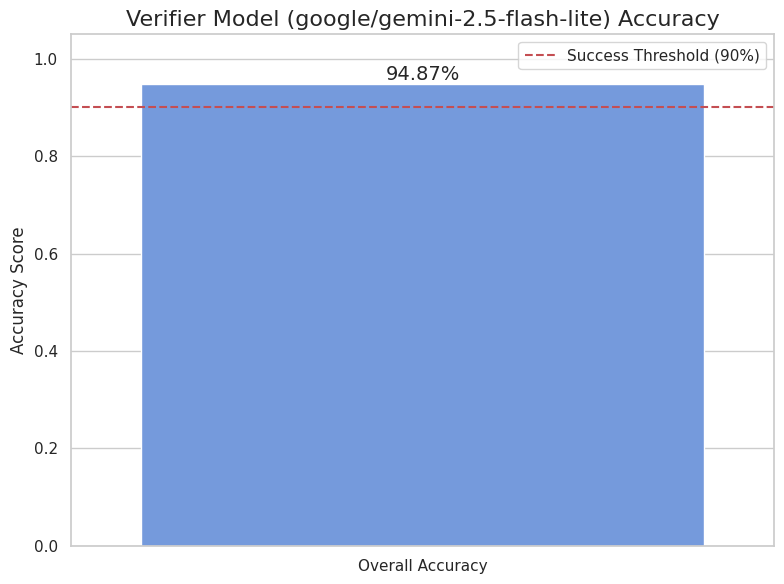

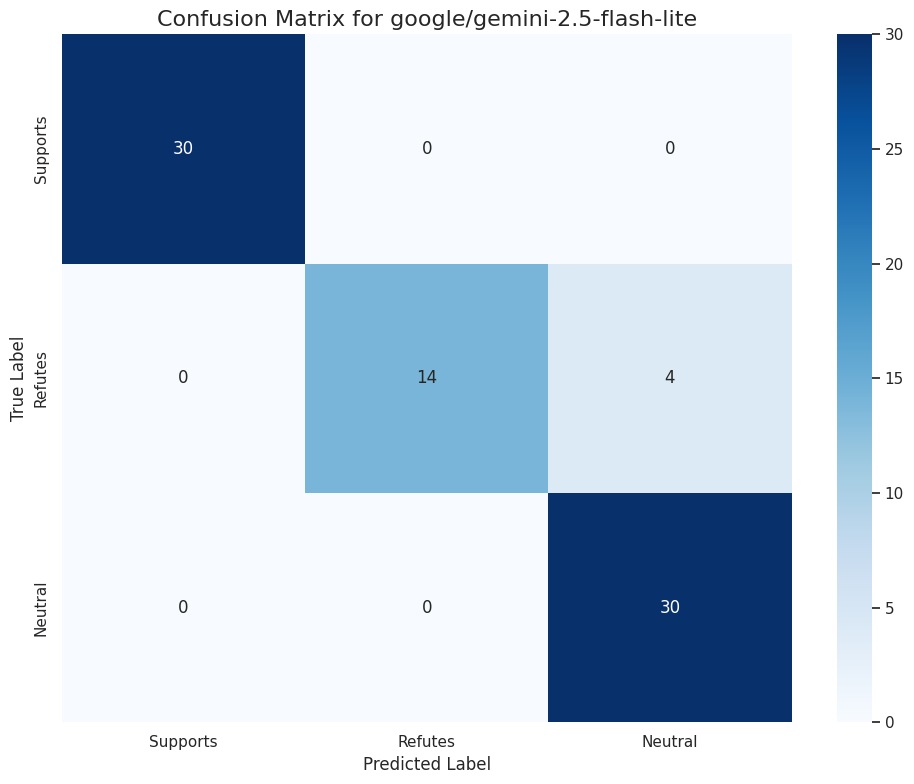

In [42]:
main()